# Лабораторная работа №5.
## Применение сверточных нейронных сетей (бинарная классификация)


### Данные
Набор данных DogsVsCats, который состоит из изображений различной размерности, содержащих фотографии собак и кошек. 
Обучающая выборка включает в себя 25 тыс. изображений (
    12,5 тыс. кошек: cat.0.jpg, …, cat.12499.jpg и 
    12,5 тыс. собак: dog.0.jpg, …, dog.12499.jpg), 
а контрольная выборка содержит 12,5 тыс. неразмеченных изображений. 
Скачать данные, а также проверить качество классификатора на тестовой выборке можно на сайте 
Kaggle -> https://www.kaggle.com/c/dogs-vs-cats/data


### Задания
- [x] Загрузите данные. Разделите исходный набор данных на обучающую, валидационную и контрольную выборки.
- [x] Реализуйте глубокую нейронную сеть с как минимум тремя сверточными слоями. Какое качество классификации получено?
- [x] Примените дополнение данных (data augmentation). Как это повлияло на качество классификатора? 
- [x] Поэкспериментируйте с готовыми нейронными сетями (например, AlexNet, VGG16, Inception и т.п.), применив передаточное обучение. 
- [x] Как это повлияло на качество классификатора? Улучгилась
- [x] Какой максимальный результат удалось получить на сайте Kaggle? Почему?


In [1]:
import os

import warnings
warnings.filterwarnings('ignore')

import random
import zipfile
from pathlib import Path

import numpy as np

import IPython.display as display
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow.keras as K
from sklearn.model_selection import train_test_split

In [2]:
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

unzip_dir = Path('data/dogs-vs-cats')
test1_dir = unzip_dir / 'test1'
train_dir = unzip_dir / 'train'

data_zip = Path('data/dogs-vs-cats.zip')
test1_zip = unzip_dir / 'test1.zip'
train_zip = unzip_dir / 'train.zip'

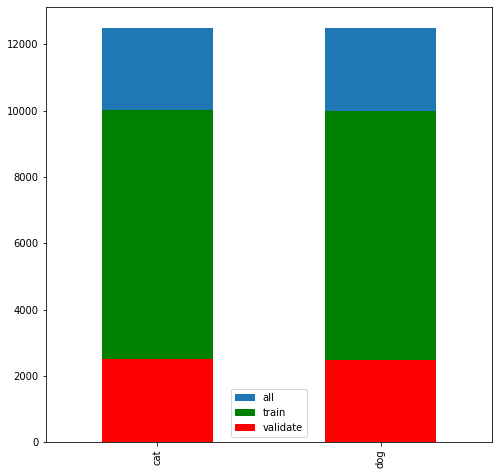

In [3]:
# Extract data
for src, dest in zip([data_zip, test1_zip, train_zip], [unzip_dir, test1_dir, train_dir]):
    if not dest.exists():
        with zipfile.ZipFile(src, 'r') as zip_ref:
            zip_ref.extractall(unzip_dir)


# Read data
all_image_paths = []
all_image_labels = []
for name in os.listdir(train_dir):
    label, id, _ = name.split('.')
    all_image_paths.append(name)
    all_image_labels.append(label)


# Split train validate
df = pd.DataFrame({
    'image_path': all_image_paths,
    'label': all_image_labels,
})
train_df, validate_df = train_test_split(df, test_size=0.20)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

_, ax = plt.subplots(1, 1, figsize=(8, 8))
df['label'].value_counts().plot.bar(ax=ax)
train_df['label'].value_counts().plot.bar(ax=ax, color='green')
validate_df['label'].value_counts().plot.bar(ax=ax, color='red')
ax.legend(['all', 'train', 'validate'])

In [24]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

train_datagen_params = {
    'rescale': 1./255,
}
train_datagen = K.preprocessing.image.ImageDataGenerator(**train_datagen_params)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    train_dir, 
    x_col='image_path',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

validation_datagen = K.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    train_dir, 
    x_col='image_path',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [7]:
model = K.models.Sequential([
    K.layers.Conv2D(kernel_size=(3, 3), filters=3, input_shape=(128, 128, 3),activation="relu"),
    K.layers.Conv2D(kernel_size=(3, 3), filters=10, activation="relu", padding="same"),
   
    K.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
    K.layers.Conv2D(kernel_size=(3, 3), filters=3, activation="relu"),
    K.layers.Conv2D(kernel_size=(5, 5), filters=5, activation="relu"),
    
    K.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    K.layers.Conv2D(kernel_size=(2,2), strides=(2,2), filters=10),
    
    K.layers.Flatten(),
    K.layers.Dropout(0.3),
    K.layers.Dense(100, activation="sigmoid"),
    
    K.layers.Dense(2,activation="softmax"),
])

model.compile(loss='categorical_crossentropy', 
              optimizer='adadelta', 
              metrics=['accuracy'])

model.load_weights('data/models/model_05_200.h5')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 126, 126, 3)       84        
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 126, 126, 10)      280       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 63, 63, 10)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 61, 61, 3)         273       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 57, 57, 5)         380       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 28, 28, 5)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 10)        210       
__________

In [8]:
history = model.fit_generator(
    train_generator, 
    epochs=10,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=[
        K.callbacks.EarlyStopping(patience=10),
        K.callbacks.ReduceLROnPlateau(
            monitor='val_acc', patience=2, verbose=1, 
            factor=0.5, min_lr=1e-6)
    ])

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
1333/1333 [==============================] - 175s 131ms/step - loss: 0.4729 - acc: 0.7733 - val_loss: 0.4493 - val_acc: 0.7908
Epoch 2/10
1333/1333 [==============================] - 168s 126ms/step - loss: 0.4496 - acc: 0.7883 - val_loss: 0.4515 - val_acc: 0.7874
Epoch 3/10
1333/1333 [==============================] - 164s 123ms/step - loss: 0.4401 - acc: 0.7986 - val_loss: 0.4645 - val_acc: 0.7793

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.5.
Epoch 4/10
1333/1333 [==============================] - 180s 135ms/step - loss: 0.4086 - acc: 0.8151 - val_loss: 0.4546 - val_acc: 0.7882
Epoch 5/10
1333/1333 [==============================] - 162s 121ms/step - loss: 0.4012 - acc: 0.8187 - val_loss: 0.4509 - val_acc: 0.7902

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.25.
Epoch 6/10
1333/1333 [==============================] - 157s 118ms/step - loss: 0.3784 - acc: 0.8315 - val_loss: 0.4395 - val_acc: 0.79

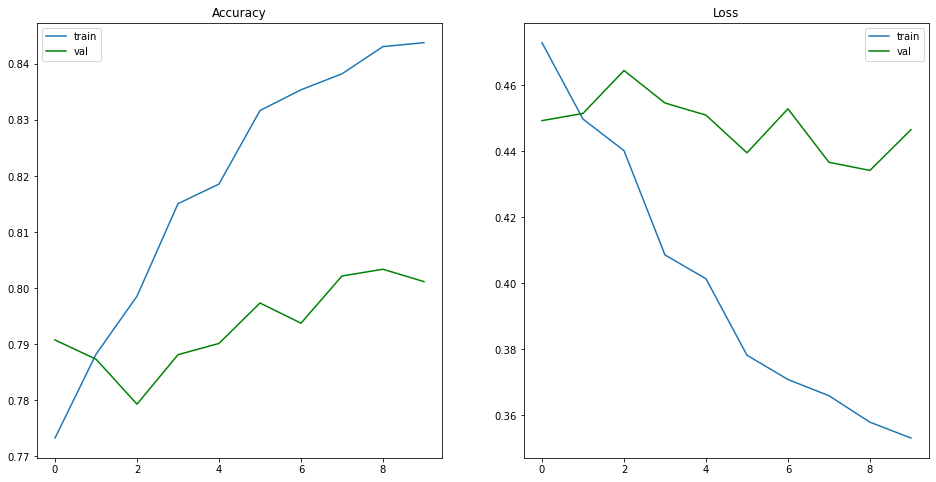

In [9]:
def plot_history(history):
    _, ax = plt.subplots(1, 2, figsize= (16, 8))

    ax[0].set_title('Accuracy')
    ax[0].plot(history.history['acc'])
    ax[0].plot(history.history['val_acc'], color='green')
    ax[0].legend(['train', 'val'], loc='best')

    ax[1].set_title('Loss')
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'], color='green')
    ax[1].legend(['train', 'val'], loc='best')


plot_history(history)

In [10]:
# Save model
model.save_weights('data/models/model_05_201.h5')

In [11]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15


train_datagen_params = {
    'rescale': 1./255,
    'rotation_range': 90.,
    'zoom_range': 0.2,
    'width_shift_range': 0.2,
    'height_shift_range': 0.2,
    'shear_range': 0.15,
    'horizontal_flip': True,
    'brightness_range': (0.2,0.8),
    'fill_mode': "nearest"
}
train_datagen = K.preprocessing.image.ImageDataGenerator(**train_datagen_params)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    train_dir, 
    x_col='image_path',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

validation_datagen = K.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    train_dir, 
    x_col='image_path',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

###
history = model.fit_generator(
    train_generator, 
    epochs=10,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=[
        K.callbacks.EarlyStopping(patience=10),
        K.callbacks.ReduceLROnPlateau(
            monitor='val_acc', patience=2, verbose=1, 
            factor=0.5, min_lr=1e-5)
    ])

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Epoch 1/10
1333/1333 [==============================] - 245s 184ms/step - loss: 0.6206 - acc: 0.6563 - val_loss: 0.5025 - val_acc: 0.7572
Epoch 2/10
1333/1333 [==============================] - 216s 162ms/step - loss: 0.6072 - acc: 0.6669 - val_loss: 0.5415 - val_acc: 0.7370
Epoch 3/10
1333/1333 [==============================] - 240s 180ms/step - loss: 0.5949 - acc: 0.6739 - val_loss: 0.5104 - val_acc: 0.7529

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.125.
Epoch 4/10
1333/1333 [==============================] - 249s 187ms/step - loss: 0.5957 - acc: 0.6772 - val_loss: 0.4993 - val_acc: 0.7563
Epoch 5/10
1333/1333 [==============================] - 235s 176ms/step - loss: 0.5941 - acc: 0.6774 - val_loss: 0.5034 - val_acc: 0.7515

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0625.
Epoch 6/10
1333/1333 [==============================] - 

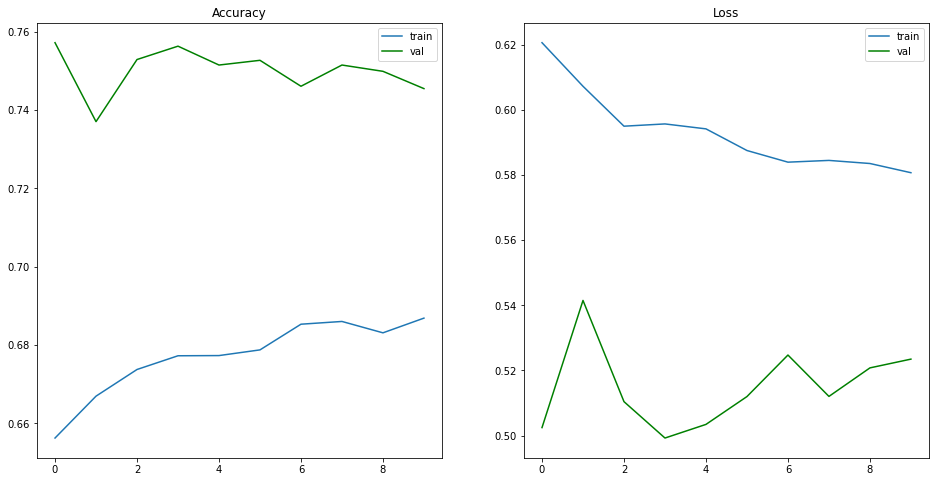

In [14]:
plot_history(history)

In [29]:
pre_trained_model = K.applications.vgg16.VGG16(
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), 
    include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False
for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
x = K.layers.GlobalAveragePooling2D()(last_output)
x = K.layers.Dense(256, activation='relu')(x)
x = K.layers.Dense(256, activation='relu')(x)
x = K.layers.Dense(2, activation='softmax')(x)

model = K.models.Model(pre_trained_model.input, x)

model.compile(loss='categorical_crossentropy',
              optimizer=K.optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [31]:
history = model.fit_generator(
    train_generator, 
    epochs=3,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=[
        K.callbacks.ReduceLROnPlateau(
            monitor='val_acc', patience=2, verbose=1, 
            factor=0.5, min_lr=1e-6)
    ]
)

Epoch 1/3
1333/1333 [==============================] - 2404s 2s/step - loss: 0.2101 - acc: 0.9113 - val_loss: 0.1554 - val_acc: 0.9364
Epoch 2/3
1333/1333 [==============================] - 2396s 2s/step - loss: 0.1200 - acc: 0.9514 - val_loss: 0.1306 - val_acc: 0.9523
Epoch 3/3
1333/1333 [==============================] - 2345s 2s/step - loss: 0.0709 - acc: 0.9725 - val_loss: 0.1689 - val_acc: 0.9492


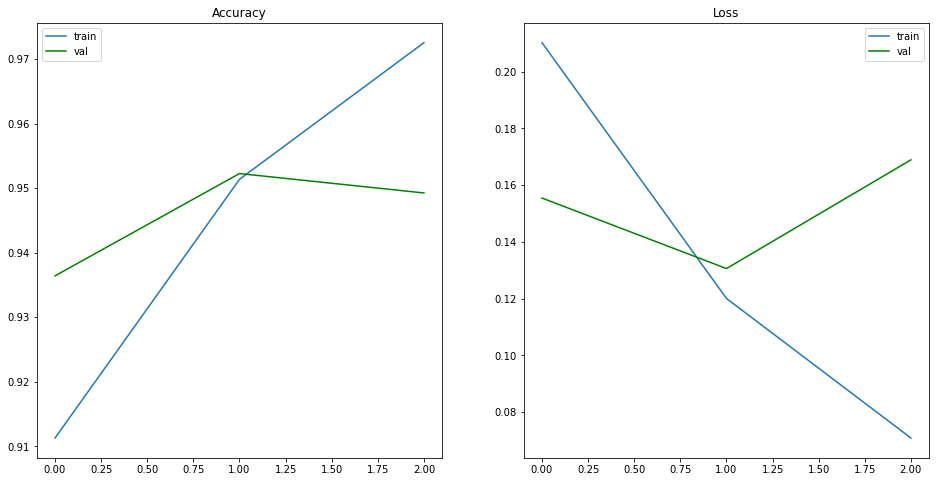

In [32]:
plot_history(history)

In [4]:
# Submit
all_image_paths = []
all_image_ids = []
for name in os.listdir(test1_dir):
    id, _ = name.split('.')
    all_image_paths.append(name)
    all_image_ids.append(id)

test_df = pd.DataFrame({
    'image_path': all_image_paths,
    'id': all_image_ids,
    'category': [-1] * len(all_image_ids)
})

In [28]:
test_gen = K.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    test1_dir, 
    x_col='image_path',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    shuffle=False,
    batch_size=1
)

Found 12500 validated image filenames.


In [29]:
model = K.models.Sequential([
    K.layers.Conv2D(kernel_size=(3, 3), filters=3, input_shape=(128, 128, 3),activation="relu"),
    K.layers.Conv2D(kernel_size=(3, 3), filters=10, activation="relu", padding="same"),
   
    K.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
    K.layers.Conv2D(kernel_size=(3, 3), filters=3, activation="relu"),
    K.layers.Conv2D(kernel_size=(5, 5), filters=5, activation="relu"),
    
    K.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    K.layers.Conv2D(kernel_size=(2,2), strides=(2,2), filters=10),
    
    K.layers.Flatten(),
    K.layers.Dropout(0.3),
    K.layers.Dense(100, activation="sigmoid"),
    
    K.layers.Dense(2,activation="softmax"),
])

# w = "data/models/model_05_100.h5",
# w = "data/models/model_05_101.h5",
w = "data/models/model_05_200.h5"
# w = "data/models/model_05_201.h5",

model.load_weights(w)
predict = model.predict_generator(test_generator, steps=len(test_df))

In [30]:
predict.shape

(12500, 2)

In [32]:
pd.DataFrame({
    "id": test_df['id'],
    "label": np.argmax(predict, axis=-1),
}).to_csv('submission.csv', index=False)